# Red Neuronal para Clasificación no Lineal

In [53]:
!pip install ipympl

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from _collections_abc import Callable
from google.colab import output

%matplotlib inline
%matplotlib widget
output.enable_custom_widget_manager()

Cree los datos de entrada y sus etiquetas:

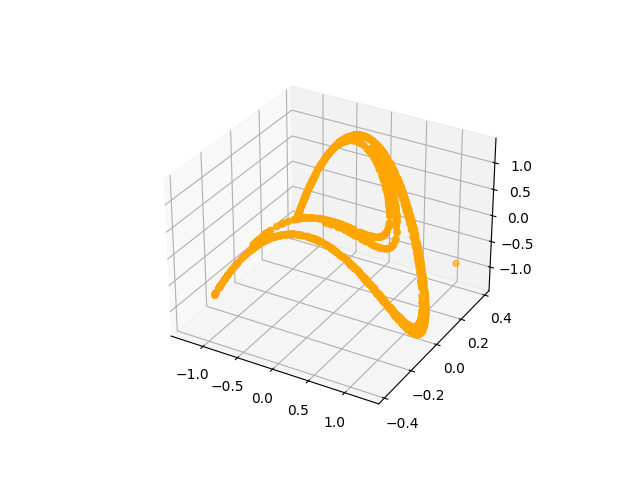

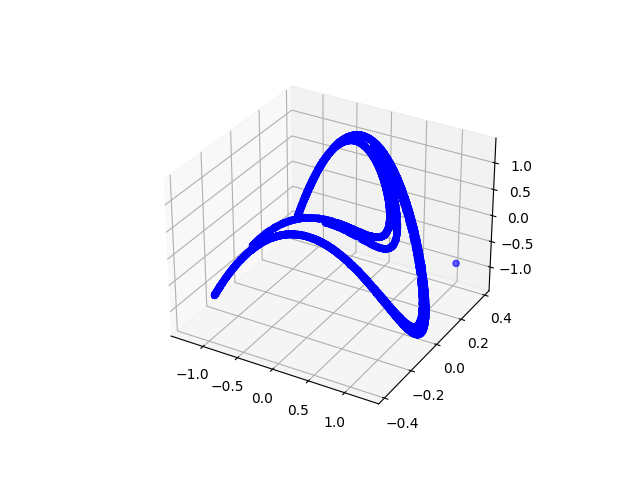

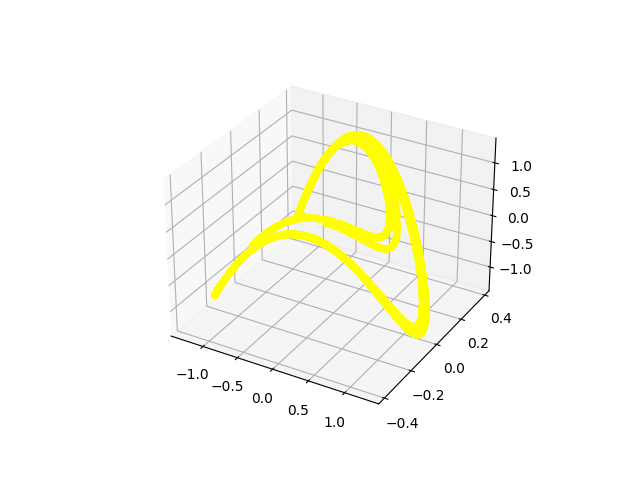

In [55]:
#Generate entry data via function
def get_data(xo:float = 1.2, yo:float = 0.3, quantity:int = 5000, a:float = 1.4, b:float = 0.3) -> list[tuple[tuple[float,float],float]]:
  prevTuple:tuple[float,float] = (xo, yo)
  data:list[tuple[tuple[float,float],float]] = []
  for i in range(quantity):
    next_x:float = 1 - a*np.power(prevTuple[0],2) + prevTuple[1]
    next_y:float = b*prevTuple[0]
    data.append( (prevTuple, next_x) ) #Create pairs {(xn, yn), xn+1}
    prevTuple = (next_x, next_y)
  return data

#Generate and split data
full_data = get_data()
random.shuffle(full_data)
separator = round(len(full_data)*0.7)
train_data = full_data[:separator] #Obtener los primeros elementos (~70% de data)
validation_data = full_data[separator:] #Obtener el resto (~30% de data)

#Assign training data and their tags
X = [data[0] for data in train_data]
y = [data[1] for data in train_data]

#Show generated data
# Get full data
x: list[float] = []
y: list[float] = []
labels: list[float] = []
for i in range(0, len(full_data)):
  x.append(full_data[i][0][0])
  y.append(full_data[i][0][1])
  labels.append(full_data[i][1])
#Graph
grafica = plt.figure().add_subplot(projection = "3d")
grafica.scatter(x, y, labels, color = "blue")

# Get train data
x: list[float] = []
y: list[float] = []
labels: list[float] = []
for i in range(0, len(train_data)):
  x.append(train_data[i][0][0])
  y.append(train_data[i][0][1])
  labels.append(train_data[i][1])
grafica = plt.figure().add_subplot(projection = "3d")
grafica.scatter(x, y, labels, color = "yellow")

# Get validation data
x: list[float] = []
y: list[float] = []
labels: list[float] = []
for i in range(0, len(validation_data)):
  x.append(validation_data[i][0][0])
  y.append(validation_data[i][0][1])
  labels.append(validation_data[i][1])
grafica = plt.figure().add_subplot(projection = "3d")
grafica.scatter(x, y, labels, color = "orange")

plt.show()

Para una red neuronal con dos neuronas en la capa de entrada, dos en la capa escondida y una en la salida, inicialize los pesos y sesgos:

In [56]:
w1 = [2 * random.random() - 1, 2 * random.random() - 1]
w2 = [2 * random.random() - 1, 2 * random.random() - 1]
w3 = [2 * random.random() - 1, 2 * random.random() - 1]

b1 = 2 * random.random() - 1
b2 = 2 * random.random() - 1
b3 = 2 * random.random() - 1

eta = 0.1

Defina la función de activación y su derivada:

In [57]:
def sigmoid(x):
    # Definicion de la función sigmoide
    return 1/(1 + math.exp(-x))

def dsigmoid(y): #Entrada: y = sigmoid(x)
    # Definicion de la derivada de la función sigmoide
    return y*(1 - y)


## Forward pass

In [58]:
#Returns ai, zi; Works per-neuron
def forward_step(inputs: list[float], weights: list[float], bias: float, activation_func: Callable[[float], float]) -> tuple[float, float]:
  y_predict = np.dot(inputs, weights) + bias

  return (activation_func(y_predict), y_predict)

## Backward pass

Implemente las derivadas del error respecto a los parámetros w y b:

In [59]:
#Returns list as follows: w11, w12, w21, w22, w31, w32, b1, b2, b3
#To-do make derivative of activation an injectable parameter instead of fixed
def get_derivatives(X:tuple[float, float], y:float, y_pred:float, Z:tuple[float,float,float], A:tuple[float,float], deriv_activation_func: Callable[[float], float]) -> list[float]:
  global w1, w2, w3, b1, b2, b3
  dE_w31 = (-1)*(y - y_pred)*(y_pred)*(1 - y_pred)*A[0]
  dE_w32 = (-1)*(y - y_pred)*(y_pred)*(1 - y_pred)*A[1]
  dE_b3 = (-1)*(y - y_pred)*(y_pred)*(1 - y_pred)*1
  dE_w21 = ( (-1)*(y - y_pred)*(y_pred)*(1 - y_pred) ) * (w3[1]) * deriv_activation_func(Z[1]) * X[0]
  dE_w22 = ( (-1)*(y - y_pred)*(y_pred)*(1 - y_pred) ) * (w3[1]) * deriv_activation_func(Z[1]) * X[1]
  dE_b2 = ( (-1)*(y - y_pred)*(y_pred)*(1 - y_pred) ) * (w3[1]) * deriv_activation_func(Z[1]) * 1
  dE_w11 = ( (-1)*(y - y_pred)*(y_pred)*(1 - y_pred) ) * (w3[0]) * deriv_activation_func(Z[0]) * X[0]
  dE_w12 = ( (-1)*(y - y_pred)*(y_pred)*(1 - y_pred) ) * (w3[0]) * deriv_activation_func(Z[0]) * X[1]
  dE_b1 = ( (-1)*(y - y_pred)*(y_pred)*(1 - y_pred) ) * (w3[0]) * deriv_activation_func(Z[0]) * 1
  result = [dE_w11, dE_w12, dE_w21, dE_w22, dE_w31, dE_w32, dE_b1, dE_b2, dE_b3]
  return result


Implemente la correción de los parámetros:

In [60]:
#NOTE. This will modify global weights and biases according to last forward pass
def backward_pass(error:float, learn_rate:float, input:list[float], y:float, y_pred:float, Z:tuple[float,float,float], A:tuple[float,float], deriv_activation_func: Callable[[float], float]):
  global w1, w2, w3, b1, b2, b3
  derivatives = get_derivatives(tuple(input), y, y_pred, Z, A, deriv_activation_func)
  w1 = (w1[0] - learn_rate * derivatives[0], w1[1] - learn_rate * derivatives[1])
  w2 = (w2[0] - learn_rate * derivatives[2], w2[1] - learn_rate * derivatives[3])
  w3 = (w3[0] - learn_rate * derivatives[4], w3[1] - learn_rate * derivatives[5])
  b1 = b1 - learn_rate * derivatives[6]
  b2 = b2 - learn_rate * derivatives[7]
  b3 = b3 - learn_rate * derivatives[8]

## Entrenamiento de la red neuronal

Use el esquema de "Retropropagación" para entrenar la red.

In [62]:
# Implementación de la retropropagación
# Trains model through feedforward and backward pass of training data given. Returns (index, error) per epoch
def train_model(train_data:list[tuple[tuple[float,float],float]], learn_rate:float, tolerance:float = np.power(10.0,-5), activation_func: Callable[[float], float] = sigmoid, deriv_activation_func: Callable[[float], float] = dsigmoid, doScale = True):
  global w1, w2, w3, b1, b2, b3
  error:float = 9999 #Initialize error with very big value
  index:int = 1

  #Scale data
  if (doScale):
    from sklearn import preprocessing

    data = []
    tag = []
    for item in train_data:
      data.append(item[0])
      tag.append(item[1])
    scaler = preprocessing.StandardScaler().fit(np.array(data))
    # min_tag = min(tag)
    # tag = [value - min_tag for value in tag] #Rescale tags for interval [0,1]
    postprocess = [scaler.transform(np.array(data)), tag]
    #Refill
    data = []
    for value in zip(postprocess[0], postprocess[1]):
      data.append( (tuple(value[0]), value[1]) )
    train_data = data

  #Train
  while error > tolerance:
    errorSum = 0
    for item in train_data:
      #Feedforward
      result1 = forward_step(list(item[0]), list(w1), b1, sigmoid)
      result2 = forward_step(list(item[0]), list(w2), b2, sigmoid)
      result3 = forward_step([result1[0], result2[0]], list(w3), b3, sigmoid)
      #Get partial error
      errorPartial = np.power(result3[0] - item[1], 2) #Error determined as (y_hat - y)^2
      errorSum += errorPartial
      #Backpropagation. This will MODIFY GLOBAL variables
      backward_pass(errorPartial, learn_rate, list(item[0]), item[1], result3[0], (result1[1], result2[1], result3[1]), (result1[0], result2[0]), dsigmoid)
    error = errorSum / len(train_data)
    yield (index, error)
    index += 1

# Print status data
def partial_printer(step_size:int):
  acc = 0
  big_acc = 1
  while True:
    acc += 1
    if (acc == step_size):
      print(f"Step {acc * big_acc} reached successfully")
      acc = 0
      big_acc += 1
    yield

# Train model with generated data
errorList = [[],[]]
trainer = train_model(train_data, 1.3 * np.power(10.0, -5))
printer = partial_printer(100)
for i in range(2000):
  result = next(trainer)
  errorList[0].append(result[0])
  errorList[1].append(result[1])
  next(printer)

KeyboardInterrupt: 

In [ ]:
# Merely encapsulating the prediction process
# NOTE. Only use after training
def predict_data(data:list[tuple[float,float]]) -> list[float]:
  global w1, w2, w3, b1, b2, b3
  label_list:list[float] = []
  for item in data:
    result1 = forward_step(list(item), list(w1), b1, sigmoid)
    result2 = forward_step(list(item), list(w2), b2, sigmoid)
    result3 = forward_step([result1[0], result2[0]], list(w3), b3, sigmoid)
    label_list.append(result3[0])
  return label_list

Valide del entrenamiento. Con una gráfica del error en funcion de las épocas.

In [ ]:
# Gráfica Error vs. Épocas
grafica = plt.figure().add_subplot()
grafica.plot(errorList[0], errorList[1], color = "red")
plt.show()

In [ ]:
# Get actual labels
x: list[float] = []
y: list[float] = []
labels: list[float] = []
for i in range(0, len(validation_data)):
  x.append(validation_data[i][0][0])
  y.append(validation_data[i][0][1])
  labels.append(validation_data[i][1])

# Get predicted labels
input_data = [item[0] for item in validation_data]
labels_pred : list[float] = predict_data(input_data)

# Graph actual versus predictions
grafica = plt.figure().add_subplot(projection = "3d")
grafica.scatter(x, y, labels, color = "blue")
grafica.scatter(x, y, labels_pred, color = "red")
plt.show()

# Calculate MSE
error = 0
for item in zip(labels, labels_pred):
  error += np.power(item[0] - item[1], 2)
error = error / len(labels)
print("Mean Squared Error\n", error)

Support for third party widgets will remain active for the duration of the session. To disable support:

## Probando con Keras

In [51]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

training_x: list[float] = []
training_y: list[float] = []
training_labels: list[float] = []


from sklearn import preprocessing

data = []
tag = []
for item in train_data:
  data.append(item[0])
  tag.append(item[1])
scaler = preprocessing.StandardScaler().fit(np.array(data))
# min_tag = min(tag)
# tag = [value - min_tag for value in tag] #Rescale tags for interval [0,1]
postprocess = [scaler.transform(np.array(data)), tag]
#Refill
data = []
for value in zip(postprocess[0], postprocess[1]):
  data.append( (tuple(value[0]), value[1]) )
scaled_train_data = data

for i in range(0, len(scaled_train_data)):
  training_x.append(scaled_train_data[i][0][0])
  training_y.append(scaled_train_data[i][0][1])
  training_labels.append(scaled_train_data[i][1])

model = keras.Sequential()
model.add(layers.Dense(units = 2, activation = "sigmoid", input_dim = 2))
model.add(layers.Dense(units = 1, activation = "sigmoid"))
#model.add(keras.Input(shape = (2,)))
model.build()
#optimizer = keras.optimizers.SGD()
model.compile(optimizer = keras.optimizers.SGD(), loss = keras.losses.MeanSquaredError())
model.summary()
#lst = [np.array(training_x), np.array(training_y)]
lst = np.array([np.array(item) for item in zip(training_x, training_y)])
lbls = np.array([np.array(item) for item in training_labels])
print(np.array(lst).shape)
#arr = np.array(lst)


model.fit(lst, lbls, epochs = 500)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                     │ (None, 2)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

(3500, 2)
Epoch 1/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6977
Epoch 2/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6387
Epoch 3/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6100
Epoch 4/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5846
Epoch 5/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5514
Epoch 6/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5470
Epoch 7/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5425
Epoch 8/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5396
Epoch 9/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4984
Epoch 10/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5350
Epoch 11/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5195
Epoch 12/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4965
Epoch 13/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5207
Epoch 14/500
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5163
Epoch 15/500
110/110 ━━━━━━━━━━━━

In [63]:
eval_lst = np.array([np.array(item) for item in zip(x, y)])

predict_lbls = model.predict(eval_lst)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


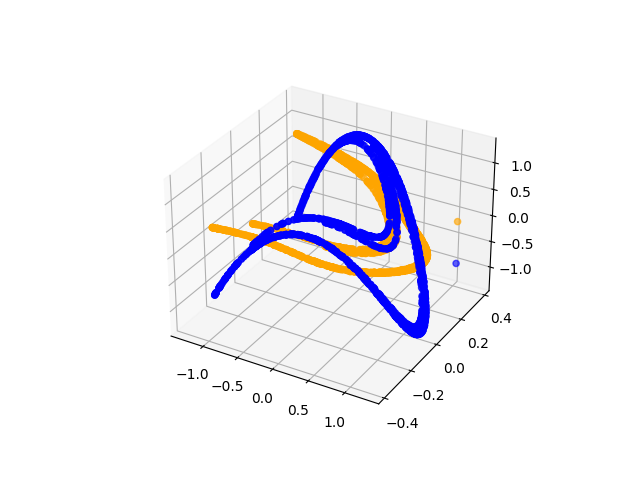

In [64]:
grafica = plt.figure().add_subplot(projection = "3d")
grafica.scatter(x, y, labels, color = "blue")
grafica.scatter(x, y, predict_lbls, color = 'orange')
plt.show()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()